In [1]:
import os
import warnings
import numpy as np
import numpy.ma as ma
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import scipy 
import healpy as hp

import astropy.units as u
from astropy.coordinates import SkyCoord

# from rubin_sim
import rubin_sim.utils as rs_utils
import rubin_sim.maf as maf
from rubin_sim.scheduler.utils import Sky_area_generator

# from this repo (survey_strategy)
import survey_utils as su

Healpix slicer using NSIDE=64, approximate resolution 54.967783 arcminutes


In [2]:
# This is from a fork in the TVS software_tools repo at https://github.com/rhiannonlynne/software_tools
# the fork just lets the software work as an importable module (PR has been submitted)
# Note you need to also install astropy_healpix into the rubin environment (pip install astropy_healpix)
import sys
sys.path.extend(['/Users/lynnej/other_repos/'])

from tvs_software_tools import generate_gp_maps

## Set up survey footprint ##

We have incorporate a survey footprint generator class into rubin_sim: 
https://github.com/lsst/rubin_sim/blob/main/rubin_sim/scheduler/utils/sky_area.py

This lets you easily generate a general footprint map incorporates the areas serving the various science pillars of the LSST. 

Using the default values, you find the baseline survey footprint. 

This Sky_area_generator class is intended to be both a tool to help build a survey footprint and evaluate approximately the overall time required and whether it suits your science priorities, and also a tool to help evaluate a simulated survey against those goals. 

In [3]:
# Curious about the resolution of various nside healpix grids? 
# The scheduler usually runs at nside=32 to both make the calculations reasonably fast and also because this
# approximately matches 1/2 the rubin FOV

for nside in [8, 16, 32, 64]:
    print(f'At nside {nside}, resolution is {np.degrees(hp.nside2resol(nside))} degrees')

At nside 8, resolution is 7.329037678543799 degrees
At nside 16, resolution is 3.6645188392718997 degrees
At nside 32, resolution is 1.8322594196359498 degrees
At nside 64, resolution is 0.9161297098179749 degrees


In [4]:
# Set up baseline sky coverage.
nside = 64

# Sky_area_generator - from rubin_sim/scheduler/utils
sky = Sky_area_generator()

# Set up the default maps per 'region' (dust-free WFD, galactic bulge, magellanic clouds, )
# The maps have values between 0-1, but the goal (peak) number of visits per region is also stored.
# (the default for each of these is 'True', except for ddf as they are typically programmed otherwise)
sky.set_maps(dustfree=True, mcs=True, gp=True, nes=True, scp=True, ddf=True)
# Note that you can set these up individually as well. 
for m in sky.maps:
    print(f'{m} with peak {sky.nvis[m]} visits')
    
# Then each region is combined, using combine_maps, to get an overall footprint. 
sky.combine_maps()

dustfree with peak 855 visits
mcs with peak 855 visits
gal with peak 855 visits
nes with peak 299 visits
scp with peak 120 visits
ddf with peak 18000 visits


In [5]:
# Quick estimates of overall survey subscription - we'll get into more details per-area velow.
area, srd_area, subscription = su.calc_area_time(sky.total, 1)
print(f'Quick estimate of overall survey subscription {subscription}')

Quick estimate of overall survey subscription 1.0066801615372465


0.0 180.0 -180.0 180.0
0.0 180.0 -180.0 180.0
0.0 180.0 -180.0 180.0
0.0 180.0 -180.0 180.0
0.0 180.0 -180.0 180.0
0.0 180.0 -180.0 180.0
0.0 180.0 -180.0 180.0


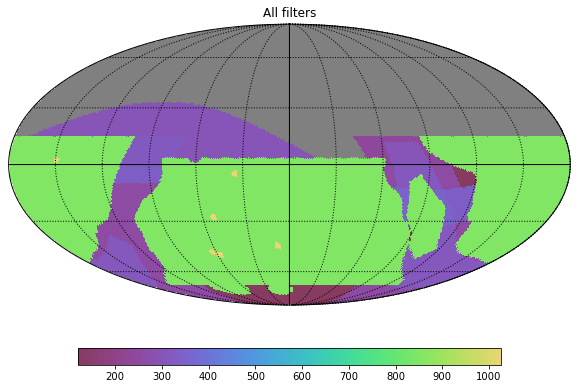

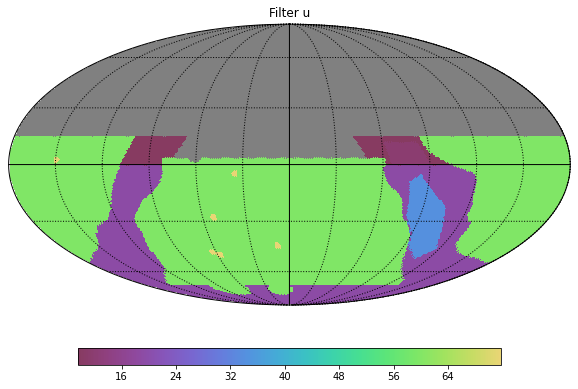

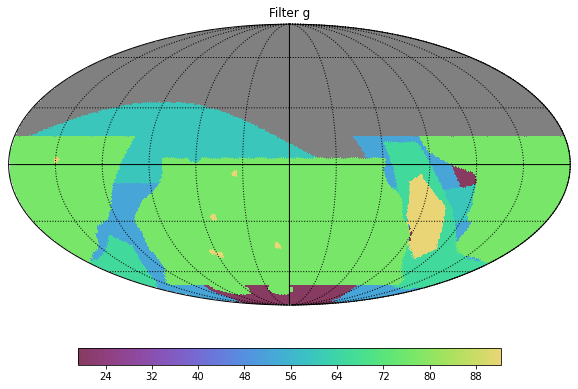

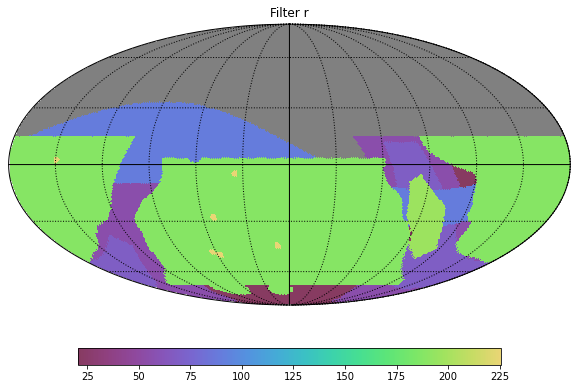

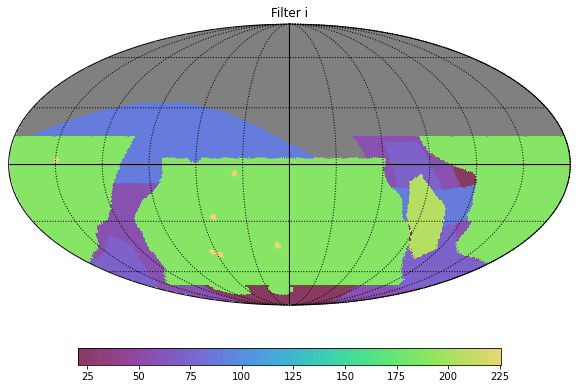

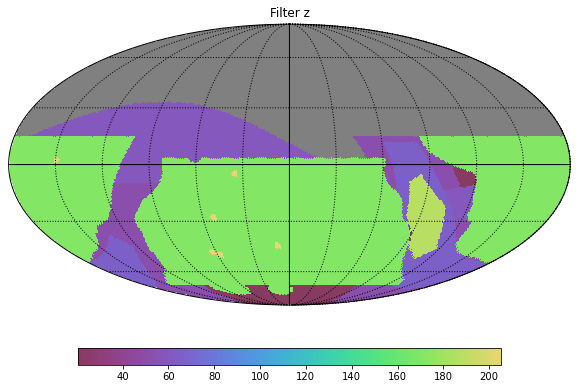

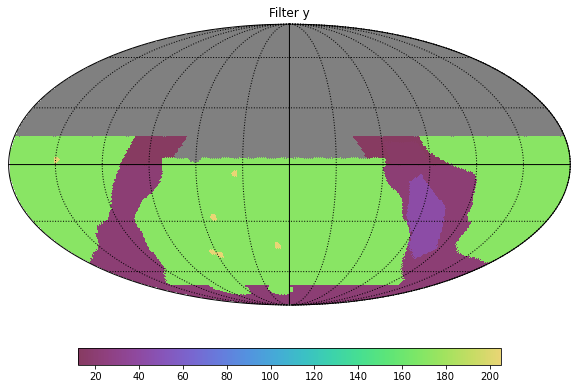

In [6]:
# Plot these.
colorMax = np.percentile(sky.total, 98) * 1.2
su.plot_sky(sky.total, 
            plotDict={'title':  'All filters', 'colorMax': colorMax, 'figsize': (8, 6)})
for f in sky.filterlist:
    colorMax = np.percentile(sky.total_perfilter[f], 98) * 1.2
    su.plot_sky(sky.total_perfilter[f], 
                plotDict={'title': f'Filter {f}', 'colorMax': colorMax, 'figsize': (8, 6)})

# Regions within the overall survey footprint #

## Low-dust extinction WFD

This area is the primary contributor to the SRD requirements (absolute minimum in both nvisits and area: 15000 sq deg to 750 visits). Design goals are 18,000 sq deg to 825 visits per pointing. This pushes the low-dust-extinction footprint toward bigger area; note that this may require rolling cadence implementation over this area, in order to recover SN performance (SN performance prefers more visits, preferably closer to 1000, which is the stretch goal).

There is some overlap between this area and the GP priority map footprint above, which may require visits in different filters (and those visits may even need to be at different cadences). 
The 'trim_overlap' option causes the footprints to be trimmed in these areas according to the higher-resolution dust extinction values - low-dust == low-dust filter balance, high-dust == galactic filter balance.

0.0 180.0 -180.0 180.0


dust limit 0.199
dec min -70
dec max 15


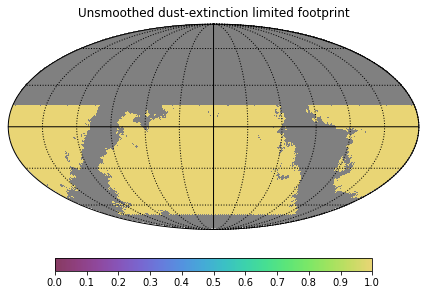

In [7]:
# Define extragalactic WFD between decMin and decMax with low dust extinction (dust extinction limit = 0.2)


#sky._set_exwfd(dust_limit=dust_limit, dec_min=dec_min, dec_max=dec_max, nvis_exwfd=nvis_exgal,
#              smoothing_cutoff=0.57, smoothing_beam=10,
#              exgal_filter_balance=exgal_filter_balance, adjust_halves=True)

print('dust limit', sky.dust_limit)
print('dec min', sky.dec_min)
print('dec max', sky.dec_max)


# Where is this (detailed dust footprint) on the sky?
plotDict = {'colorMin': 0, 'colorMax': 1, 'title': 'Unsmoothed dust-extinction limited footprint'}
su.plot_sky(sky.dustfree, plotDict)

Now - we don't want to leave 'islands' unobserved within this WFD area and we want a smoother boundary at the dust extinction edges. So we've also smoothed the dust-extinction edges.  From later work looking at RA-oversubscription, the option 'adjust_halves' is also used to reduce the area in high-demand RA regions.

0.0 180.0 -180.0 180.0


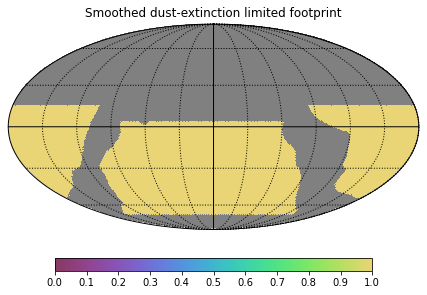

In [8]:
plotDict = {'colorMin': 0, 'colorMax': 1, 'title': 'Smoothed dust-extinction limited footprint'}
su.plot_sky(sky.maps['dustfree'], plotDict)

area within dust_boundary wfd 17736.79260424759
dust-free area within dust-boundary wfd 17213.07336963582

area = 2 is added into smoothed dust boundary (too much dust, but now included),
 area = 1 is overlap (good dust and in smoothed boundary),
 and area = -1 would pass dust limit but is not included


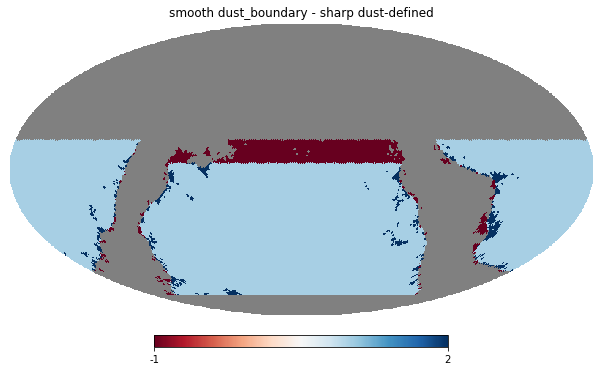

In [9]:
lowdust_area, srd_area, t_exgal = su.calc_area_time(sky.maps['dustfree'], sky.nvis['dustfree'])
dust_free_area, j, j = su.calc_area_time(sky.maps['dustfree'][np.where(sky.dustmap < sky.dust_limit)], sky.nvis['dustfree'])

print('area within dust_boundary wfd', lowdust_area)
print('dust-free area within dust-boundary wfd', dust_free_area)

tmp = sky.maps['dustfree'] * 2 - sky.dustfree
tmp = np.where(tmp == 0, hp.UNSEEN, tmp)
hp.mollview(tmp, title='smooth dust_boundary - sharp dust-defined', cmap='RdBu')
print('')
print('area = 2 is added into smoothed dust boundary (too much dust, but now included),\n '\
      'area = 1 is overlap (good dust and in smoothed boundary),\n '\
      'and area = -1 would pass dust limit but is not included')

In [10]:
# Summary of area/time.

print(f'Area in low-extinction wfd {lowdust_area}')
print(f'Area in low-extinction wfd which is below dust-limit {dust_free_area}')

# survey time required? 
print(f"Survey fraction required for low-extinction WFD area {lowdust_area: .2f}, at {sky.nvis['dustfree']} "\
      f"visits per pointing is {t_exgal: .3f}")

Area in low-extinction wfd 17736.79260424759
Area in low-extinction wfd which is below dust-limit 17213.07336963582
Survey fraction required for low-extinction WFD area  17736.79, at 855 visits per pointing is  0.786


## Galactic Plane ##

Using the "galactic plane priority map" defined by the TVS/SMWLV groups to set some information about 'ideal' coverage. However, this is also a complicated mapping so we will again use a simpler definition of area around bulge and use galactic plane priority map as weighting to evaluate priority.

In [11]:
# The trilegal maps are only available at nside=64 and 128, but the TVS code needs nside=64.
gp_maps = generate_gp_maps(nside=64)

/Users/lynnej/other_repos/tvs_software_tools/generate_galplane_priority_maps.py:50: RuntimeWarning: divide by zero encountered in log10
  hp_log_star_density = np.log10(hp_star_density)


filter gal-balance low-dust-balance
u 0.04 0.07
g 0.22 0.09
r 0.24 0.22
i 0.24 0.22
z 0.22 0.2
y 0.05 0.2


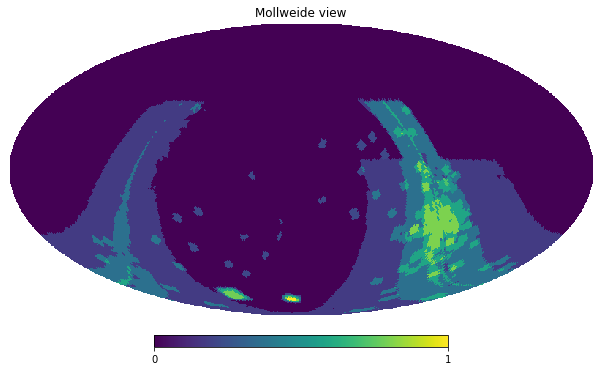

In [12]:
# gal plane priority maps are per filter - use this to get desired filter balance and to gather all-band priority map
gal_total = np.zeros(len(gp_maps['r']), float)
for f in gp_maps:
    gal_total += gp_maps[f]
    #print(f, gp_maps[f].max(), gp_maps[f].min())
# Scale so the peak is 1 (to assign total number of visits across all filters later)
norm = gal_total.max()
gal_total = gal_total / norm

gal_filter_balance = {}
print('filter gal-balance low-dust-balance')
for f in sky.filterlist:
    gal_filter_balance[f] = round(gp_maps[f].max() / norm, 2)
    print(f, gal_filter_balance[f], sky.dustfree_wfd_filter_balance[f])

hp.mollview(gal_total, max=1)

There is not enough time available to observe the entire map to 825 visits per pointing, but we can do a hybrid -- take some fraction of the map and observe that to 825 visits per pointing and then observe the rest at the fraction given in the map. Use this to evaluate generally how much area we might be able to cover, for later reference. 

In [14]:
nvis_gal_peak = 825
for X in np.arange(0, 1.05, 0.1):
    gal_total = np.zeros(len(gp_maps['r']), float)
    for f in gp_maps:
        gal_total += gp_maps[f]
    norm = gal_total.max()
    gal_total = gal_total / norm
    gal_total = np.where(sky.maps['dustfree'] == 1, 0, gal_total)
    # 'flatten' the map at 'X' - and set this to 825 visits per pointing. 
    # Remainder of plane will be at specified level relative to 825 (i.e. parts get 80 visits pp)
    gal_total = np.where(gal_total > X, 1, gal_total)
    eff_area, gp_srd_area, frac = su.calc_area_time(gal_total, nvis_gal_peak)
    print(f'{X:.2f} Effective area {eff_area:.2f} (SRD area {gp_srd_area:.2f}) Survey fraction {frac :.3f}')

0.00 Effective area 7250.66 (SRD area 7250.66) Survey fraction 0.310
0.10 Effective area 7250.66 (SRD area 7250.66) Survey fraction 0.310
0.20 Effective area 4633.34 (SRD area 4082.32) Survey fraction 0.198
0.30 Effective area 4564.37 (SRD area 3994.20) Survey fraction 0.195
0.40 Effective area 2881.02 (SRD area 1318.53) Survey fraction 0.123
0.50 Effective area 2867.17 (SRD area 1290.83) Survey fraction 0.123
0.60 Effective area 2522.19 (SRD area 455.74) Survey fraction 0.108
0.70 Effective area 2522.19 (SRD area 455.74) Survey fraction 0.108
0.80 Effective area 2516.59 (SRD area 432.24) Survey fraction 0.108
0.90 Effective area 2433.50 (SRD area 7.55) Survey fraction 0.104
1.00 Effective area 2433.50 (SRD area 7.55) Survey fraction 0.104


So we could try to use X=0.7 and see what that looks like. (we know we have an oversubscription problem, but this gives us a bit more SRD area for not a lot of time). 
BUT, this does give a pretty complicated looking footprint - which we're trying to avoid. And it also leaves parts of the plane with very little coverage. 

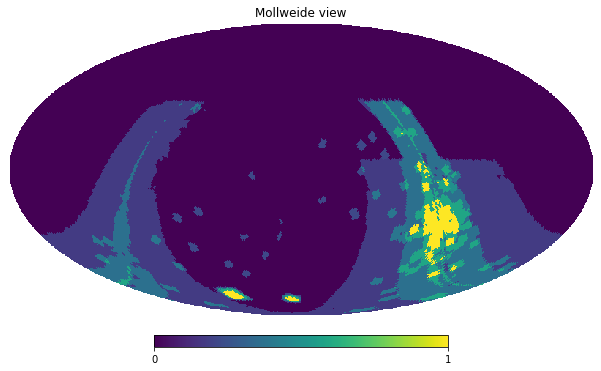

In [15]:
X = 0.7

gal_total = np.zeros(len(gp_maps['r']), float)
for f in gp_maps:
    gal_total += gp_maps[f]
gal_total = gal_total / gal_total.max()
gal_total = np.where(gal_total > X, 1, gal_total)
hp.mollview(gal_total)

So now let's look at the comparison with the simpler sky map coverage.

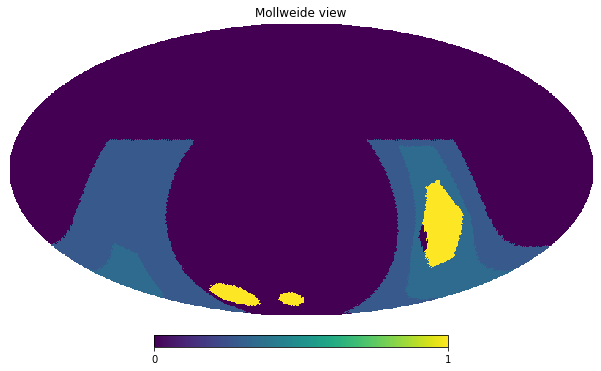

In [16]:
tmp = sky.maps['gal'] + sky.maps['mcs']
hp.mollview(tmp)


area = 0 matches coverage in priority map, area = 1 is more coverage, area = -1 is missed area


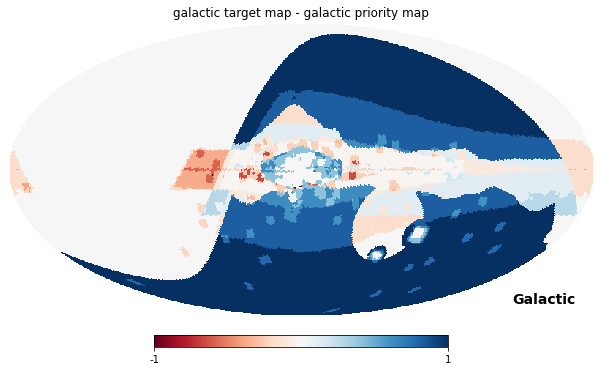

In [17]:
# Compare to priority map
t = (np.maximum(tmp, sky.maps['dustfree'])) - gal_total
hp.mollview(t, cmap='RdBu', coord=['C', 'G'], 
            title='galactic target map - galactic priority map')
print('')
print('area = 0 matches coverage in priority map, area = 1 is more coverage, area = -1 is missed area')

In [18]:
tmp = np.where(sky.maps['dustfree']==0, tmp, 0)
gal_eff_area, gal_srd_area, t_gal = su.calc_area_time(tmp, sky.nvis['gal'])
print(f"effective area in galactic plane {gal_eff_area}, srd contributed area {gal_srd_area}")
print(f"fraction of survey time required {t_gal}")

effective area in galactic plane 2485.6206474975706, srd contributed area 908.9550177636936
fraction of survey time required 0.11019584870572563


## Ecliptic coverage ##

The ecliptic plane has significant overlap with over survey coverage as well. The extragalactic WFD is compatible, so will use that wherever it overlaps. The GP coverage may have different filter / time requirements, but needs more details to check. The ecliptic coverage needs to pick up some pointings around the outside edges of the plane which were not included in the galactic plane priority map -- this is worth checking with the solar system collaboration, as these visits may not be the most useful due to stellar confusion (but are in very interesting areas of the sky for exploration, as these have not generally been covered yet).

ecliptic latitude min -10
ecliptic latitutde max 10
ecliptic dec cutoff -10


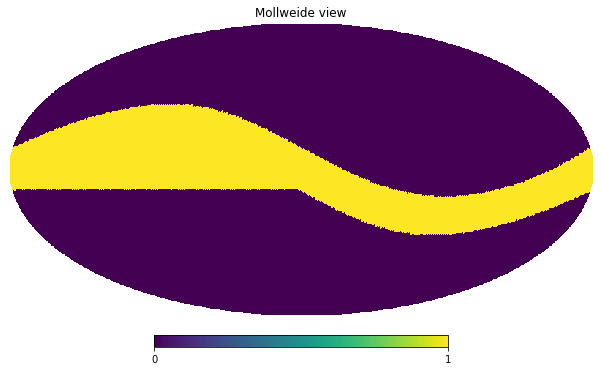

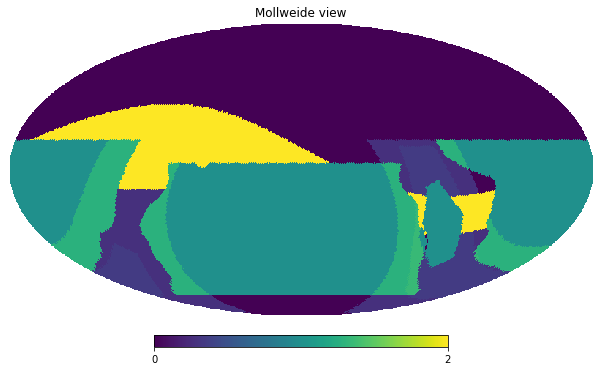

In [19]:
# Ecliptic latitude limits are not symmetric because the northern most point of the ecliptic is +23
print('ecliptic latitude min', sky.eclat_min)
print('ecliptic latitutde max', sky.eclat_max)
print('ecliptic dec cutoff', sky.eclip_dec_min)

hp.mollview(sky.maps['nes'], norm=None)

tmp = np.where((sky.maps['dustfree'] == 1) | (sky.maps['gal'] > .4), 0, sky.maps['nes'])
hp.mollview(tmp*2 + sky.maps['dustfree'] + sky.maps['gal'], max=2)

In [20]:
# how much area is covered? 
nes_area, j, t_nes = su.calc_area_time(tmp, sky.nvis['nes'])

print(f'Area in ecliptic plane total {nes_area}')
print(f"Survey fraction required for covering north ecliptic spur {nes_area: .2f}"
      f"at {sky.nvis['nes']} visits per pointing {t_nes:.3f}")

Area in ecliptic plane total 3887.6081646181246
Survey fraction required for covering north ecliptic spur  3887.61at 299 visits per pointing 0.060


## Southern Celestial Pole ##

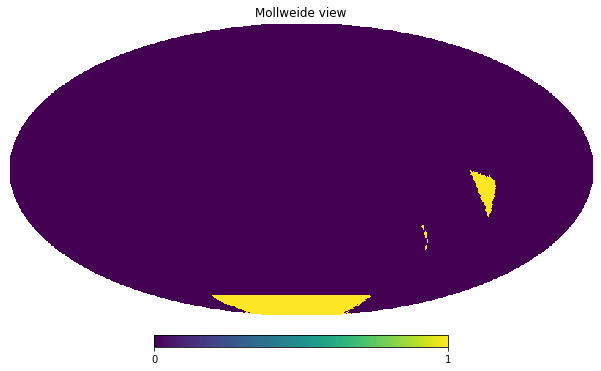

In [21]:
# Add light coverage to the southern celestial pole - the southern part of the sky that is not already covered.
tmp = np.where((sky.maps['dustfree'] == 1) | (sky.maps['gal'] > 0.2), 0, sky.maps['scp'])
hp.mollview(tmp)

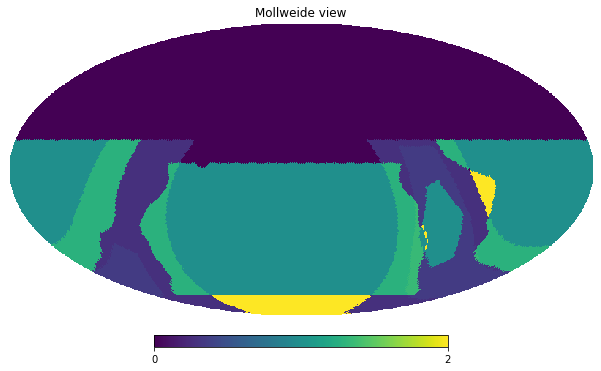

In [22]:
hp.mollview(tmp*1000 + +sky.maps['dustfree'] + sky.maps['gal'], max=2)

In [23]:
scp_area, j, t_scp  = su.calc_area_time(tmp, sky.nvis['scp'])
print(f'Area in southern celestial pole {scp_area}')

print(f"Survey fraction required for south celestial pole {scp_area: .2f}, at {sky.nvis['scp']} visits per pointing {t_scp: .3f}")

Area in southern celestial pole 960.1519301215748
Survey fraction required for south celestial pole  960.15, at 120 visits per pointing  0.006


## Total ##

In [24]:
# We need at least 5% of the time for DDFs - 1% per pointing
# The setup in the footprint above uses slightly more than 5% (?)
t_ddf = 0.05
ddf_area = t_ddf / .01 * 9.6
# We need a few percent for mini-minisurveys (ToO, twilight NEO? DCR?)
t_mini = 0.03
# But for this exercise, let's leave it at 0
t_mini = 0

There is very little survey overlap at this point (some in the NES though)

In [25]:
# Start with a basic survey footprint, just adding all of the above together.
surveyfootprint, survey_maps = sky.total, sky.total_perfilter

In [26]:
# We do need to check that we're planning for about 18k sq deg to be visited to at least 825 per SRD
nvis_min_srd = 750
goal_srd = len(np.where(surveyfootprint >= nvis_min_srd)[0]) * hp.nside2pixarea(nside, degrees=True)
res_srd = len(np.where(surveyfootprint >= 825)[0]) * hp.nside2pixarea(nside, degrees=True)
print(f"Area covered to at least {nvis_min_srd} visits per pointing {goal_srd}")
print(f"Area covered to at least {825} visits per pointing {res_srd}")

Area covered to at least 750 visits per pointing 18645.74762201128
Area covered to at least 825 visits per pointing 18645.74762201128


In [27]:
t_total = t_exgal + t_gal + t_nes + t_scp
t_total += t_ddf + t_mini
# effective total area (because we're discounting parts of the GP which are not covered at full depth ..)
area_total = lowdust_area + gal_eff_area + nes_area  + scp_area + ddf_area

pd.DataFrame([[lowdust_area, t_exgal, sky.nvis['dustfree']], 
              [gal_eff_area, t_gal, sky.nvis['gal']],
              [nes_area, t_nes, sky.nvis['nes']], 
              [scp_area, t_scp, sky.nvis['scp']], 
              [ddf_area, t_ddf, np.nan], 
              [np.nan, t_mini, np.nan],
              [area_total, t_total, np.nan]], 
             columns=["Area (sq deg)", "Survey Fraction", "Nvis/pointing"], 
             index=["Extragalactic", "GP map", "NES",  "SCP", "DDF", "Mini", "Total"])

,Area (sq deg),Survey Fraction,Nvis/pointing
Extragalactic,17736.792604,0.786331,855.0
GP map,2485.620647,0.110196,855.0
NES,3887.608165,0.060272,299.0
SCP,960.151930,0.005974,120.0
DDF,48.000000,0.050000,NaN
Mini,NaN,0.000000,NaN
Total,25118.173346,1.012774,NaN


0.0 180.0 -180.0 180.0


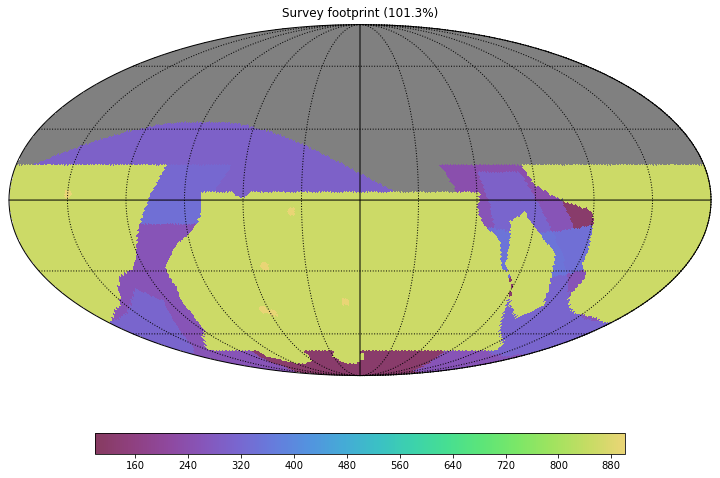

In [29]:
plotDict = {'title': f'Survey footprint ({t_total*100:.1f}%)', 
            'colorMax': 900, 'colorMin':100, 'figsize': (10, 8)}
su.plot_sky(surveyfootprint, plotDict)

0.0 180.0 -180.0 180.0
0.0 180.0 -180.0 180.0
0.0 180.0 -180.0 180.0
0.0 180.0 -180.0 180.0
0.0 180.0 -180.0 180.0
0.0 180.0 -180.0 180.0


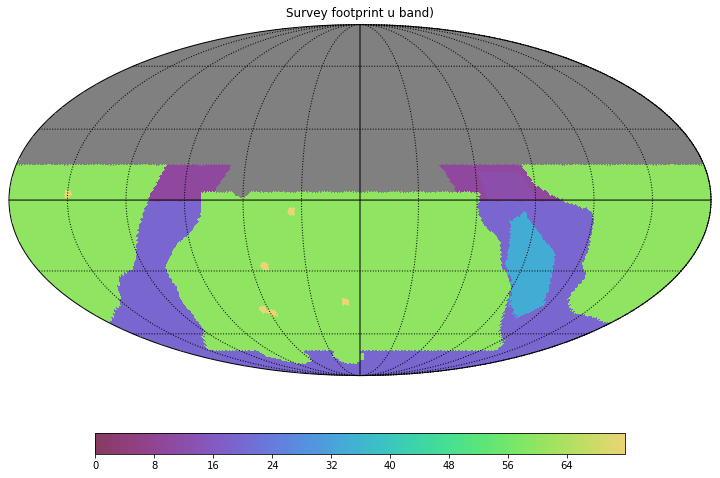

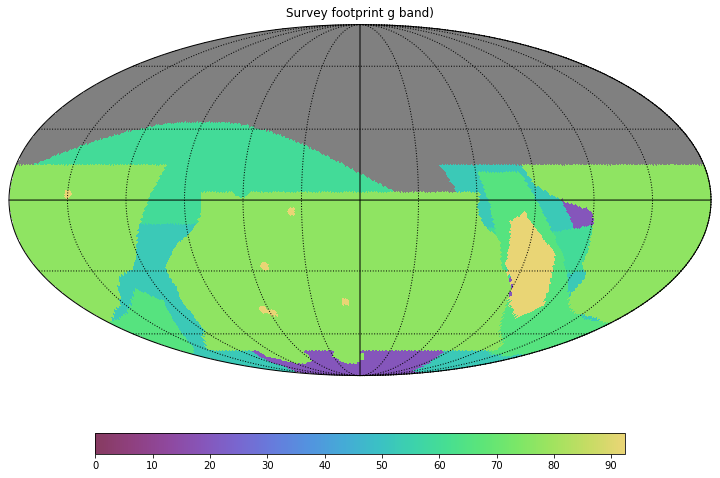

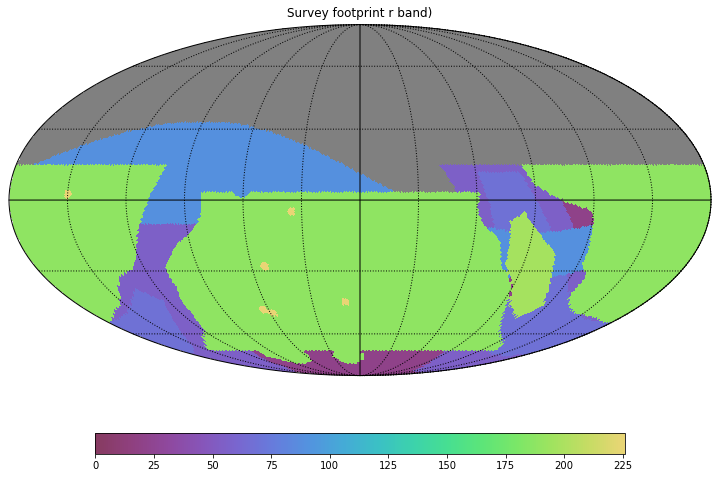

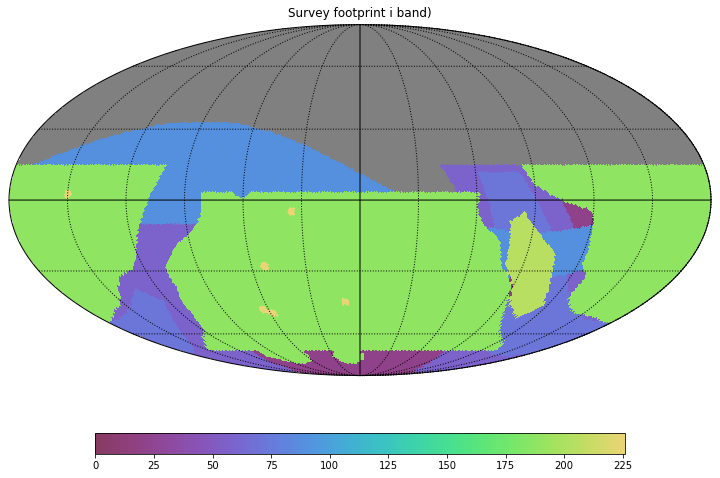

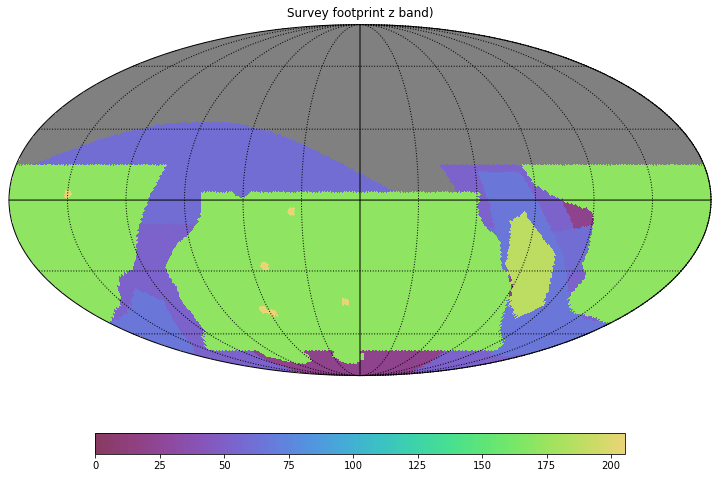

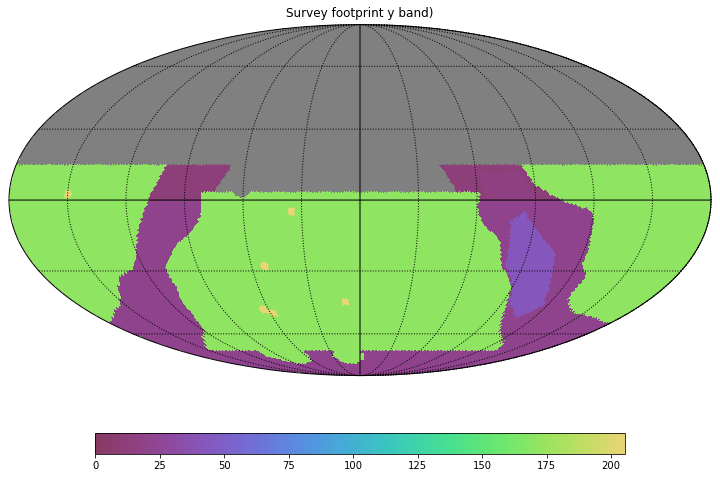

In [30]:
for f in sky.filterlist:
    plotDict = {'title': f'Survey footprint {f} band)', 'figsize': (10, 8),
               'colorMin': 0, 'colorMax': np.percentile(survey_maps[f], 98) * 1.2}
    su.plot_sky(survey_maps[f], plotDict)

Generally, this map described what we ask for and can hopefully expect from the simulator. In reality, there are some other effects we need to consider:
* the scaling is not 100% accurate .. generally, it seems like simulations show an overall difference of about 3% (i.e. if we scale our total footprint to match the total available survey time, in "reality" we will only reach about 97% of the footprint .. but the scheduler does take this effect out as evenly as possible across all regions in the footprint, so the result is that we will likely have about 3% fewer visits per pointing than we might otherwise expect)
* the footprint doesn't account for over or undersubscription as a function of RA (more on this below)
* the 'edges' of the footprint can be inefficient -- we've smoothed them at each stage above, but in general they can also be a source of differences between the expected time required and the actual simulated time required
* as always, weather and telescope downtime are likely to affect final survey performance.

## Time available at each RA range ##

One of the big problems we find when we look at this in a simulation is that some areas of the sky are oversubscribed while others are undersubscribed.  We can try to estimate this by looking at the survey area as a function of RA (as a function of visibility would be better, but RA + HA seems likely to get pretty close). 
And then also to look at time available throughout the year and likely impact of weather and scheduled shutdowns. 

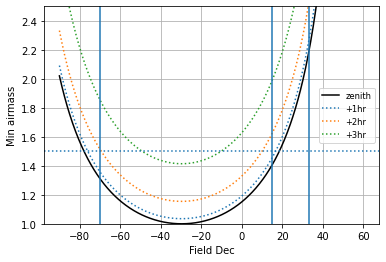

In [31]:
# Want to weight footprint 
tele_lat = -29.666667

dec_min = np.max([tele_lat-90, -90])
dec_max = np.min([tele_lat+90, 90])
field_dec = np.arange(dec_min, dec_max, 0.25)

min_z = np.radians(np.abs(field_dec - tele_lat))
min_airmass = 1 / np.cos(min_z)

plt.plot(field_dec, min_airmass, 'k-', label='zenith')

# Add expected airmass for +/- X hours around meridian
# cos z  =cos(min_z) * cos(ha_offset)
for x in [1, 2, 3]:
    ha_offset = np.radians(x * 15)
    plus_x = np.arccos(np.cos(min_z) * np.cos(ha_offset))
    airmass_x = 1. / np.cos(plus_x)
    plt.plot(field_dec, airmass_x, linestyle=':', label=f'+{x}hr')

plt.legend(loc='right', fancybox=True, fontsize='small')
plt.xlabel('Field Dec')
plt.ylabel('Min airmass')
plt.axvline(sky.dec_min)
plt.axvline(sky.dec_max)
plt.axvline(23+sky.eclat_max)
plt.axhline(1.5, linestyle=':')
plt.ylim(1, 2.5)
plt.grid(True)

0.0 180.0 -180.0 180.0


5915192.913793181 4852252.829044549


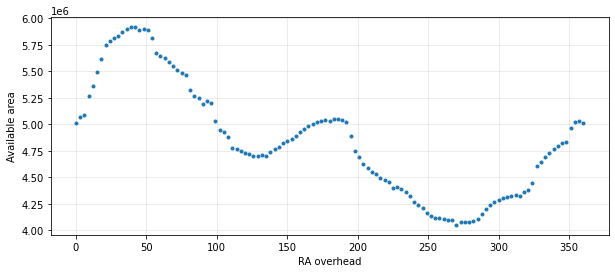

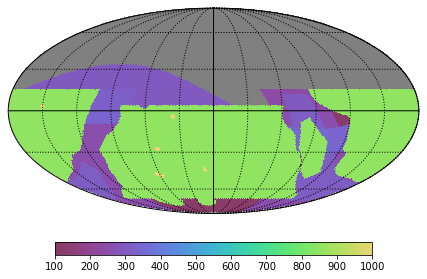

In [38]:
# So don't really want to push visits beyond +/- 2 (max 3?) HA (HA = LST - RA) 
ra, area = su.average_ra_window(sky, haRange=3)

plt.figure(figsize=(10, 4))
plt.plot(ra, area, linestyle='', marker='.')
plt.grid(True, alpha=0.3)
plt.ylabel('Available area')
plt.xlabel('RA overhead')
print(area.max(), area.mean())
su.plot_sky(sky.total, {'colorMin': 100, 'colorMax': 1000})

start 2023-12-31T16:43:00.000, window HA 2.0


Text(0.5, 0, 'RA')

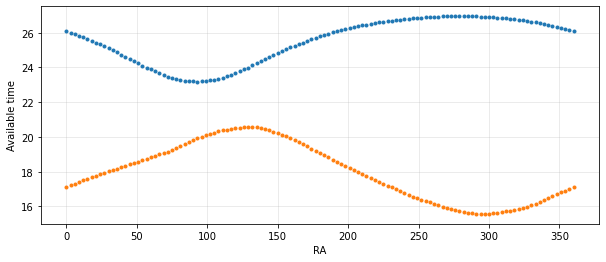

In [36]:
calculate_time_available = False

from astropy.time import Time
from astropy.coordinates import EarthLocation

if calculate_time_available:
    
    from datetime import datetime
    import pytz
    import rubin_sim.site_models as rs_site
    
    # Set up local midnight (and account for timezone)
    tz = 'Chile/Continental'
    timezone = pytz.timezone(tz)
    time = datetime(year=2024, month=1, day=1, hour=0, minute=0, second=0, tzinfo=timezone)

    lsst_loc = EarthLocation.of_site('Cerro Pachon')
    mjd_midnight = Time(time, location=lsst_loc)
    lst_midnight = mjd_midnight.sidereal_time('apparent')

    print(mjd_midnight.isot, mjd_midnight.utc.mjd, lst_midnight.deg)

    mjd_start = mjd_midnight - 0.5
    print(mjd_start)

    # Get the site (scheduled) downtime
    dt = rs_site.ScheduledDowntimeData(mjd_start)
    dt.read_data()
    mod_downtimes = [((t[0].mjd - mjd_start.mjd) % 365.25, (t[1].mjd - mjd_start.mjd) % 365.25) for t in dt()]

    # Get the sunrise/sunset times and the cloud/weather times
    cloud_limit=0.3
    almanac = rs_site.Almanac(mjd_start=mjd_start.mjd)
    cloud_data = rs_site.CloudData(mjd_start, offset_year=0)

    # Set up a grid of times and look at what is going on at each of those times 
    nyrs = 10
    spacing = 1/24/10.0
    print(f'{nyrs} yrs at {spacing} days ({spacing*60} hours)')
    mjds = np.arange(mjd_start.utc.mjd, mjd_start.utc.mjd+365.25*nyrs, 1/24/10.)
    times = Time(mjds, format='mjd', scale='utc', location=lsst_loc)
    # These are UTC times, but the location means we get the RA which is overhead
    lst = times.sidereal_time('mean').deg

    # This is slow ...but retrieve the information
    bulk_cloud = [cloud_data(time) for time in times]
    sun_moon_info = almanac.get_sun_moon_positions(mjds)

    # Identify 'good' (dark and low cloud) and 'sun_down' (just dark) times of night
    good = np.where((sun_moon_info['sun_alt'] < np.radians(-12.)) & (np.array(bulk_cloud) < cloud_limit))[0]
    sun_down = np.where((sun_moon_info['sun_alt'] < np.radians(-12)))[0]

    # This almanac method identifies which almanac entries are relevant for these mjds
    almanac_indx = almanac.mjd_indx(mjds)
    # And this identifies which 'nights' correspond to these entries
    nights = almanac.sunsets['night'][almanac_indx]

    # How much time do we have available at different days in the year?
    times = np.ones(np.size(good))*(mjds[1]-mjds[0])*24
    all_times = np.ones(np.size(sun_down))*(mjds[1]-mjds[0])*24

    n = nights[good] % 365
    # fudge the bins because there's something weird going on at the start (?)
    bins = np.arange(5., 366, 1)
    hours_available, be, bi = scipy.stats.binned_statistic(n, times, bins=bins, statistic=np.sum)

    all_hours_possible, be, bi = scipy.stats.binned_statistic((nights[sun_down] % 365), all_times,
                                                  bins=bins, statistic=np.sum)

    # Generate a plot of up/down time.
    night_binned = (be[1:]+be[:-1])/2
    plt.plot(night_binned, hours_available/nyrs, label='Mean, Clouds < 3/10')
    plt.plot(night_binned, all_hours_possible/nyrs, label='Possible')
    plt.xlabel(f'Night (modulo 365 over {nyrs} years)')
    plt.ylabel('Time Available (Hours)')
    plt.title('Sun < -18 degrees altitude')
    plt.legend()

    for dt in mod_downtimes:
        plt.fill_between(dt, [0,0], y2=[15,15], alpha=.05, color='orange')
    plt.ylim([2,12])

    # Estimate the amount of time we could spend at any given RA value, smoothing this over 2 hrs of time
    # (i.e. RA is considered 'available' for +/- 2 hrs of time around the LST being overhead)
    ha_limit = 2 * 15
    step = 3
    ra = np.arange(0, 360  + step/2, step)
    time_ra_sun = np.zeros(len(ra), float)
    time_ra_good = np.zeros(len(ra), float)
    for i, ra_cen in enumerate(ra):
        # consider wrap-around at RA=0, but calculate a running window's width of 'area' 
        # this is the area available within ha_limit when a given RA is overhead
        window = np.where((np.abs(lst[sun_down] - ra_cen) < ha_limit) | 
                          (np.abs(lst[sun_down] - ra_cen) > (360 - ha_limit)), 1, 0)
        time_ra_sun[i] = len(lst[np.where(window == 1)]) * (spacing / nyrs )
        window = np.where((np.abs(lst[good] - ra_cen) < ha_limit) | 
                          (np.abs(lst[good] - ra_cen) > (360 - ha_limit)), 1, 0)
        time_ra_good[i] = len(lst[np.where(window == 1)]) * (spacing / nyrs )

    # Save to disk so we can just re-read this next time
    np.savez('hours_available', ra=ra, time_ra_sun=time_ra_sun, time_ra_good=time_ra_good, 
             start_time=mjd_start.mjd, window=ha_limit/15)

else:
    d = np.load('hours_available.npz')
    ra = d['ra']
    time_ra_sun = d['time_ra_sun']
    time_ra_good = d['time_ra_good']
    lsst_loc = EarthLocation.of_site('Cerro Pachon')
    mjd_start = Time(d['start_time'], format='mjd', scale='utc', location=lsst_loc)
    window_HA = d['window']
    print(f'start {mjd_start.isot}, window HA {window_HA}')

# Plot the time available as a function of RA
plt.figure(figsize=(10, 4))
plt.plot(ra, time_ra_sun, linestyle='', marker='.')
plt.plot(ra, time_ra_good, linestyle='', marker='.')
plt.grid(True, alpha=0.3)
plt.ylabel('Available time')
plt.xlabel('RA')

0.0 180.0 -180.0 180.0


4216617.987890064 3233621.9298568987


0.0 180.0 -180.0 180.0


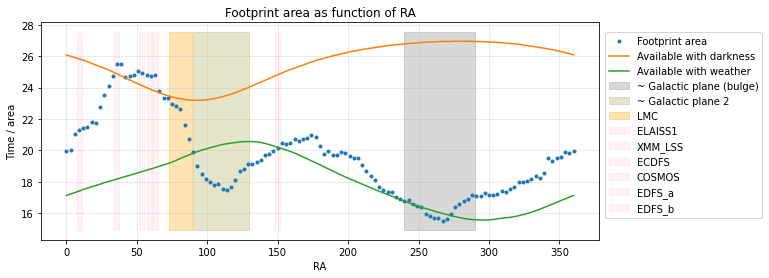

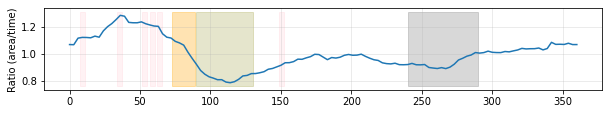

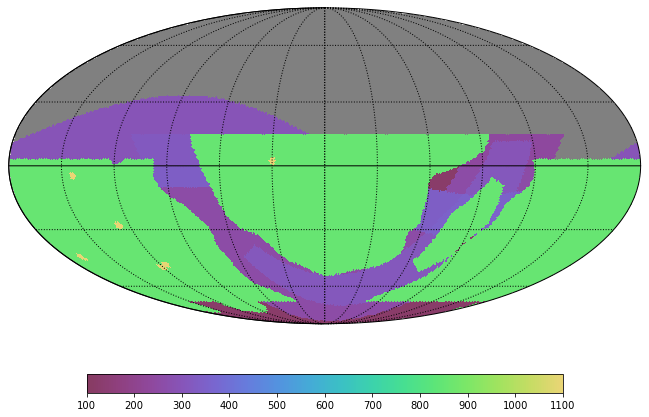

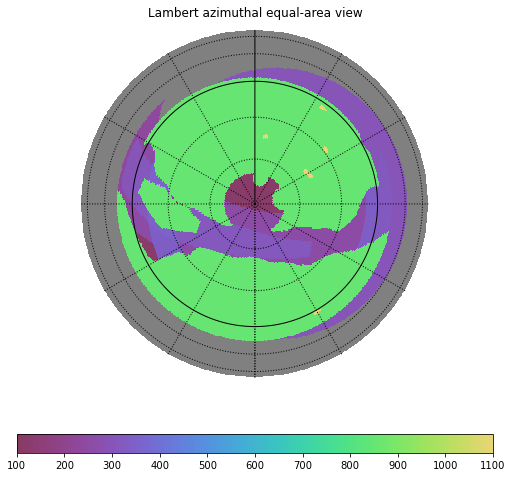

In [55]:
# calculate area in footprint in given RA range .. to include or not include window?
ra_area, area = su.average_ra_window(sky, 2)
    

def highlight_areas():
    y1, y2 = plt.ylim()
    plt.fill_between([240, 290], y1=y1, y2=y2, color='gray', alpha=0.3, label='~ Galactic plane (bulge)')
    plt.fill_between([90, 130], y1=y1, y2=y2, color='olive', alpha=0.2, label='~ Galactic plane 2')
    plt.fill_between([(sky.lmc_ra - sky.lmc_radius), (sky.lmc_ra + sky.lmc_radius)], 
                     y1=y1, y2=y2, color='orange', alpha=0.3, label='LMC')
    if 'ddf' in sky.maps:
        for dd in sky.ddf_centers:
            plt.fill_between([sky.ddf_centers[dd][0] - sky.ddf_radius, sky.ddf_centers[dd][0] + sky.ddf_radius],
                             y1=y1, y2=y2, color='pink', alpha=0.2, label=f'{dd}')
    return


plt.figure(figsize=(10, 4))
plt.title('Footprint area as function of RA')
# The factor 25.5 is calibrated using the actual opsim footprint and simulation result below.
# The actual simulation below indicates that generally we should stay under the orange (dark time)
# line, and preferably close to the green line, but that because how we're windowing time available
# and footprint area over a given HA range, it can probably vary between the two reasonably widely. 
# (also I suspect the DDFs get observed at high airmass/large HA, which is borne out in the alt/az plots)
plt.plot(ra_area, area/area.max() * 25.5, linestyle='', marker='.', label='Footprint area')
plt.plot(ra, time_ra_sun, linestyle='-', label='Available with darkness')
plt.plot(ra, time_ra_good, linestyle='-', label='Available with weather')
plt.grid(True, alpha=0.3)
plt.ylabel('Time / area')
plt.xlabel('RA')
highlight_areas()
plt.legend(loc=(1.01, 0.1), fancybox=True)
print(area.max(), area.mean())

plt.figure(figsize=(10, 1.5))
plt.plot(ra, (area / time_ra_good) / (area / time_ra_good).mean())
plt.ylabel("Ratio (area/time)")
highlight_areas()
plt.grid(True, alpha=0.3)
plotDict={'colorMin': 100, 'colorMax': 1100, 'figsize': (9, 7),
         'rot': (180, 0, 0), 'flip': 'geo'}
su.plot_sky(sky.total, plotDict)
su.plot_sky(sky.total, plotDict, lamb=True)

## Compare/validate with existing simulations ##

In [41]:
ddir = '/Users/lynnej/opsim/fbs_1.7.1/new_rolling'
opsim = 'baseline_nexp2_v1.7.1_10yrs'
opsdb = maf.OpsimDatabase(os.path.join(ddir, opsim+'.db'))

In [42]:
# Get RA/dec of pointings as well as LST and time .. 
# add up number of visits acquired at RA slice (maybe only need RA?)
# Get footprint to look at what we were trying to get
d = opsdb.fetchMetricData(colnames=['fieldRA', 'observationStartLST', 'fieldDec', 'observationStartMJD'])

In [43]:
# Set up 'retro' sky footprint 

flat_filter_balance = {'u': 0.17, 'g': 0.165, 'r': 0.165, 'i': 0.165, 'z': 0.165, 'y': 0.158}
nes_filter_balance = {'u': 0, 'g': 0.2, 'r': 0.46, 'i': 0.46, 'z': 0.4, 'y': 0}
wfd_filter_balance = {'u': 0.29, 'g':0.43, 'r':1.0, 'i':1.0, 'z':0.88, 'y':0.88}

retro = Sky_area_generator()
retro.read_dustmap()
nvis_wfd = 900
retro._set_dustfree_wfd(nvis_wfd, dec_min=-62, dec_max=3.6, dust_limit=100000000, adjust_halves=0,
                       dustfree_wfd_filter_balance=wfd_filter_balance)
retro._set_nes(nvis_wfd * 0.337, eclat_min=-30, eclat_max=10, eclip_dec_min=3.6, dec_cutoff=3.6,
               nes_filter_balance=nes_filter_balance)
retro._set_galactic_plane(nvis_wfd*0.198, nvis_gal_B=0, nvis_gal_min=0, dec_max=35,
                          center_width_A=10, end_width_A=4, gal_long1_A=290, gal_long2_A=70,
                         gal_filter_balance=flat_filter_balance)
retro._set_scp(nvis_wfd*0.198, dec_max=-62, scp_filter_balance=flat_filter_balance)
retro._set_magellanic_clouds(nvis_mcs=0)
retro._set_ddf()
gal_mask = np.where(retro.maps['gal'] > 0)[0]
retro.maps['dustfree'][gal_mask] = 0
for f in retro.filterlist:
    retro.maps_perfilter['dustfree'][f][gal_mask] = 0
retro.combine_maps(trim_overlap=False)


area, srd_area, subscription = su.calc_area_time(retro.total/retro.nvis['dustfree'], retro.nvis['dustfree'])
print(f'Quick estimate of overall survey subscription {subscription}')
print(f'With about {srd_area} anticipated above SRD minimum nvisits')

Quick estimate of overall survey subscription 1.002611097955977
With about 19371.73662511894 anticipated above SRD minimum nvisits


0.0 180.0 -180.0 180.0
0.0 180.0 -180.0 180.0
0.0 180.0 -180.0 180.0
0.0 180.0 -180.0 180.0
0.0 180.0 -180.0 180.0
0.0 180.0 -180.0 180.0
0.0 180.0 -180.0 180.0


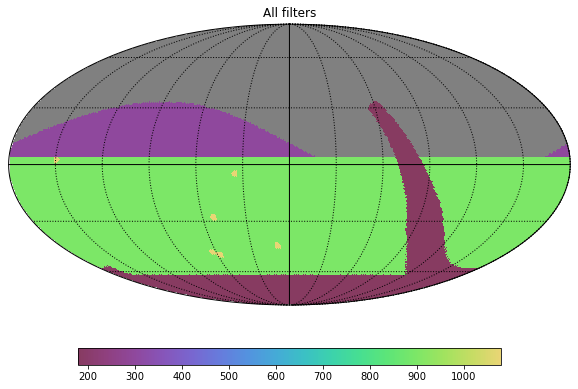

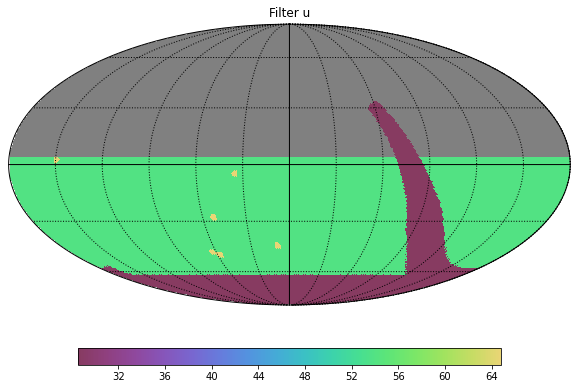

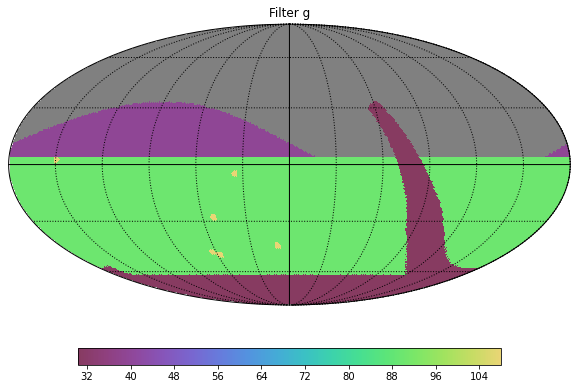

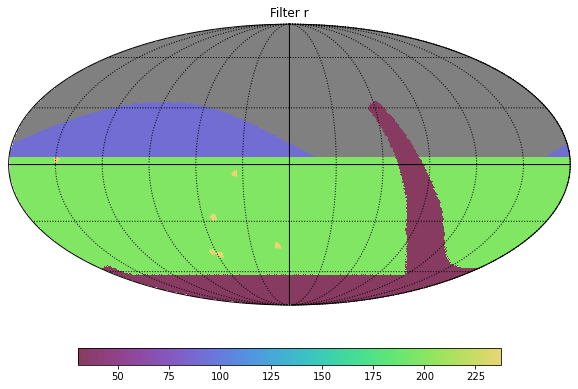

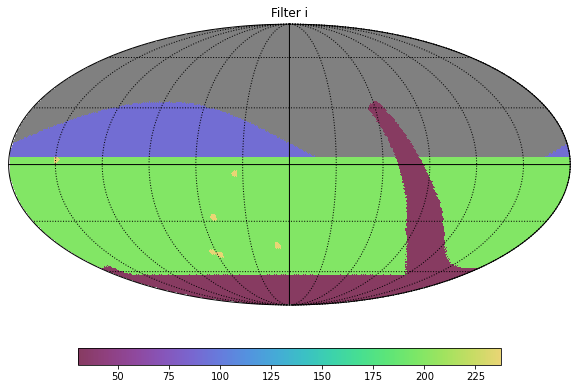

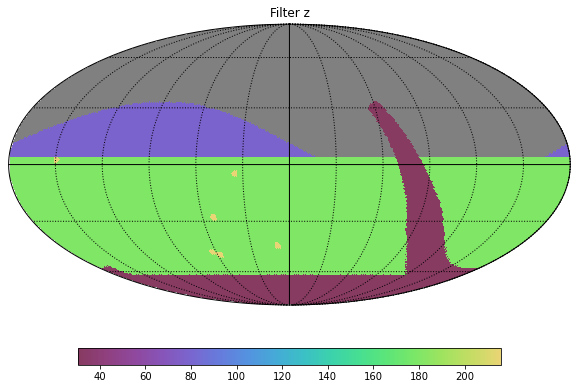

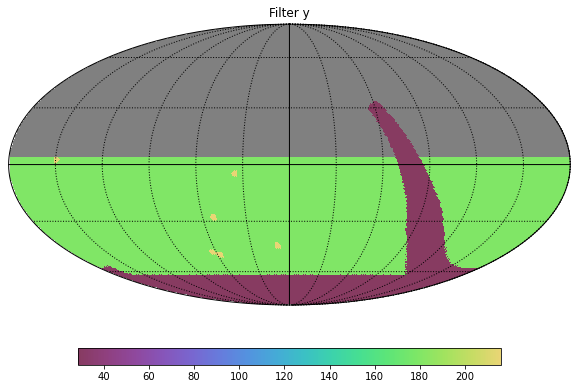

In [46]:
su.plot_footprints(retro)

In [47]:
# goal footprint as function of RA
ra_area, area = su.average_ra_window(retro, 2)

# same thing for achieved visits
step = 3
ha_limit =  2 * 15 # step * 2
ra_area = np.arange(0, 360  + step/2, step)
opsim_nvis = np.zeros(len(ra_area), float)
for i, ra_cen in enumerate(ra_area):
    # consider wrap-around at RA=0, but calculate a running window's width of 'area' 
    # this is the area available within ha_limit when a given RA is overhead
    window = np.where((np.abs(d['fieldRA'] - ra_cen) < ha_limit) | (np.abs(d['fieldRA'] - ra_cen) > 360 - ha_limit), 1, 0)
    opsim_nvis[i] = len(d['fieldRA'][np.where(window == 1)]) 

# same thing for achieved visits but in LST
step = 3
ha_limit =  0.1 * 15 # step * 2
ra_area = np.arange(0, 360  + step/2, step)
opsim_lst = np.zeros(len(ra_area), float)
for i, ra_cen in enumerate(ra_area):
    # consider wrap-around at RA=0, but calculate a running window's width of 'area' 
    # this is the area available within ha_limit when a given RA is overhead
    window = np.where((np.abs(d['observationStartLST'] - ra_cen) < ha_limit) | (np.abs(d['observationStartLST'] - ra_cen) > 360 - ha_limit), 1, 0)
    opsim_lst[i] = len(d['observationStartLST'][np.where(window == 1)]) 

0.0 180.0 -180.0 180.0


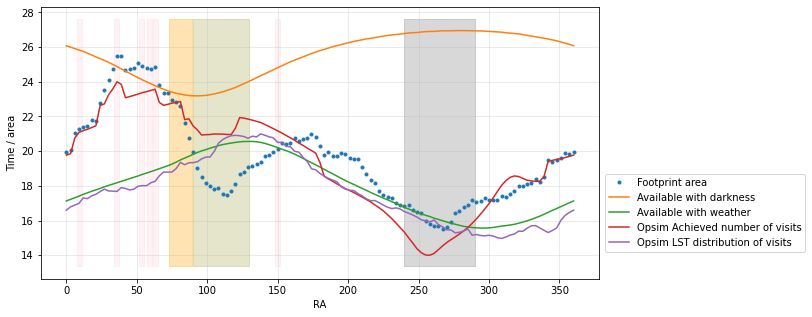

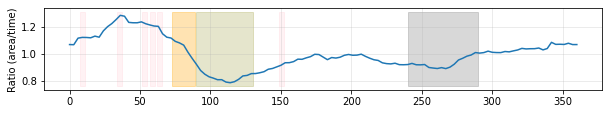

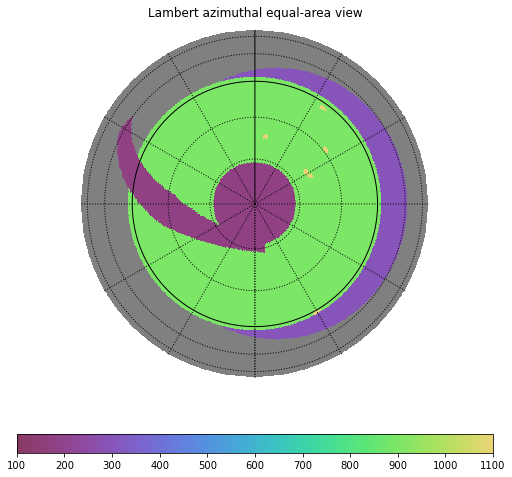

In [57]:
plt.figure(figsize=(10, 5))
plt.plot(ra_area, area/area.max() * 25.5, linestyle='', marker='.', label='Footprint area')
plt.plot(ra, time_ra_sun, linestyle='-', label='Available with darkness')
plt.plot(ra, time_ra_good, linestyle='-', label='Available with weather')
plt.plot(ra_area, opsim_nvis/opsim_nvis.max() * 24, linestyle='-', label='Opsim Achieved number of visits')
plt.plot(ra_area, opsim_lst/opsim_lst.max() * 21, linestyle='-', label='Opsim LST distribution of visits')
plt.legend(loc=(1.01, 0.1), fancybox=True)
highlight_areas()
plt.grid(True, alpha=0.3)
plt.ylabel('Time / area')
plt.xlabel('RA')

plt.figure(figsize=(10, 1.5))
plt.plot(ra, (area / time_ra_good) / (area/time_ra_good).mean())
highlight_areas()
plt.grid(True, alpha=0.3)
plt.ylabel("Ratio (area/time)")
plotDict={'colorMin': 100, 'colorMax': 1100, 'figsize': (9, 7), 'flip': 'geo'}
su.plot_sky(retro.total, plotDict, lamb=True)